# Autoencoder

- https://github.com/SherlockLiao/pytorch-beginner/tree/master/08-AutoEncoder
- https://blog.keras.io/building-autoencoders-in-keras.html

In [1]:
import os
import numpy as np
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image

In [2]:
cuda = torch.cuda.is_available()
if cuda:
    print('cuda is available!')

In [3]:
num_epochs = 100
batch_size = 128
learning_rate = 0.001
out_dir = './autoencoder'

In [4]:
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

In [5]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # [0,1] => [-1,1]
])
train_dataset = MNIST('./data', download=True, transform=img_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [6]:
print(len(train_dataset))
print(len(train_loader))

60000
469


In [7]:
class Autoencoder(nn.Module):
    
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 12),
            nn.ReLU(True),
            nn.Linear(12, 2))
        
        self.decoder = nn.Sequential(
            nn.Linear(2, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28 * 28),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = Autoencoder()
if cuda:
    model.cuda()

- encoderとdecoderを別々に作成しておくとあとで便利

In [8]:
model

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128)
    (1): ReLU(inplace)
    (2): Linear(in_features=128, out_features=64)
    (3): ReLU(inplace)
    (4): Linear(in_features=64, out_features=12)
    (5): ReLU(inplace)
    (6): Linear(in_features=12, out_features=2)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=12)
    (1): ReLU(inplace)
    (2): Linear(in_features=12, out_features=64)
    (3): ReLU(inplace)
    (4): Linear(in_features=64, out_features=128)
    (5): ReLU(inplace)
    (6): Linear(in_features=128, out_features=784)
    (7): Tanh()
  )
)

In [9]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=learning_rate,
                             weight_decay=1e-5)

In [10]:
def to_img(x):
    x = 0.5 * (x + 1)  # [-1,1] => [0, 1]
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

In [ ]:
loss_list = []

for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.view(img.size(0), -1)
        if cuda:
            img = Variable(img).cuda()
        else:
            img = Variable(img)
        
        output = model(img)
    
        # 出力画像（再構成画像）と入力画像の間でlossを計算
        loss = criterion(output, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # logging
        loss_list.append(loss.data[0])
    
    print('epoch [{}/{}], loss: {:.4f}'.format(
        epoch + 1,
        num_epochs,
        loss.data[0]))

    # 10エポックごとに再構成された画像（output）を描画する
    if epoch % 10 == 0:
        pic = to_img(output.cpu().data)
        save_image(pic, './{}/image_{}.png'.format(out_dir, epoch))

In [ ]:
np.save('./{}/loss_list.npy'.format(out_dir), np.array(loss_list))
torch.save(model.state_dict(), './{}/autoencoder.pth'.format(out_dir))

In [43]:
!gdrive download 1Ap3sZ7H4LiMoZSMEldFMscFpX_w6g2AE --recursive

- バッチサイズ128なのに12x8=96枚の画像が出力される
- 60000 % 128 = 96なので最後のバッチでは96枚の画像だけなので正しい

## 学習した潜在空間の可視化

In [12]:
model.load_state_dict(torch.load('{}/autoencoder.pth'.format(out_dir),
                                 map_location=lambda storage,
                                 loc: storage))

In [13]:
test_dataset = MNIST('./data', download=True, train=False, transform=img_transform)
test_loader = DataLoader(test_dataset, batch_size=10000, shuffle=False)

In [14]:
print(len(test_dataset))

10000


In [15]:
images, labels = iter(test_loader).next()
images = images.view(10000, -1)

In [16]:
print(images.size())
print(labels.size())

torch.Size([10000, 784])
torch.Size([10000])


In [17]:
labels.numpy().dtype

dtype('int64')

In [18]:
# 784次元ベクトルを2次元ベクトルにencode
z = model.encoder(Variable(images, volatile=True)).data.numpy()
print(z.shape)

(10000, 2)


In [19]:
z[:10]

array([[-14.752452  , -23.167349  ],
       [-14.863674  ,  10.306888  ],
       [-21.32574   ,   2.9508514 ],
       [  3.507488  ,   2.759862  ],
       [ -1.0993326 ,  -8.052351  ],
       [-15.549651  ,   2.1959815 ],
       [ -1.6112812 ,  -4.606089  ],
       [ -0.64088315,  -4.381419  ],
       [ -1.3324945 ,  -0.648768  ],
       [ -5.0102973 ,  -5.4791594 ]], dtype=float32)

In [20]:
import pylab
import matplotlib.pyplot as plt
%matplotlib inline

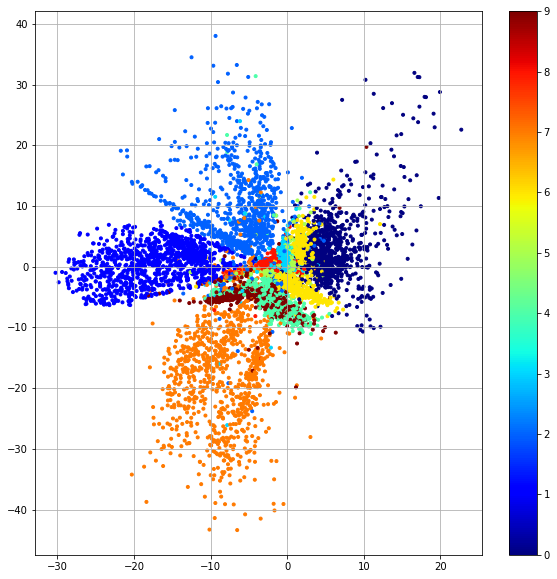

In [21]:
plt.figure(figsize=(10, 10))
plt.scatter(z[:, 0], z[:, 1], marker='.', c=labels.numpy(), cmap=pylab.cm.jet)
plt.colorbar()
plt.grid()